Library Imports

In [105]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from collections import Counter
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import time
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier

Data Loading and Preprocessing

In [106]:
# Load the dataset from the CSV file
classifier_df = pd.read_csv("wdbc.data", header=None)

# Assign column names: first column is ID, second is Diagnosis, the rest are features
columns = ["ID", "Diagnosis"] + [f"Feature_{i}" for i in range(1, 31)]
classifier_df.columns = columns

# Display the first few rows of the dataset
print(classifier_df.head())

# Drop the 'ID' column as it is not useful for classification
classifier_df = classifier_df.drop(columns=["ID"])

# Convert diagnosis labels from strings to numerical values (B = 0, M = 1)
classifier_df["Diagnosis"] = classifier_df["Diagnosis"].map({"M": 1, "B": 0})

# Extract feature values (X) and label values (y)
classifier_data_x = classifier_df.iloc[:, 1:].values  # Features
classifier_data_y = classifier_df.iloc[:, 0].values   # Labels

         ID Diagnosis  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0    842302         M      17.99      10.38     122.80     1001.0    0.11840   
1    842517         M      20.57      17.77     132.90     1326.0    0.08474   
2  84300903         M      19.69      21.25     130.00     1203.0    0.10960   
3  84348301         M      11.42      20.38      77.58      386.1    0.14250   
4  84358402         M      20.29      14.34     135.10     1297.0    0.10030   

   Feature_6  Feature_7  Feature_8  ...  Feature_21  Feature_22  Feature_23  \
0    0.27760     0.3001    0.14710  ...       25.38       17.33      184.60   
1    0.07864     0.0869    0.07017  ...       24.99       23.41      158.80   
2    0.15990     0.1974    0.12790  ...       23.57       25.53      152.50   
3    0.28390     0.2414    0.10520  ...       14.91       26.50       98.87   
4    0.13280     0.1980    0.10430  ...       22.54       16.67      152.20   

   Feature_24  Feature_25  Feature_26  Featu

In [107]:
# Read the day.csv file
df = pd.read_csv("day.csv")

# Display the first few rows
print(df.head())

# Drop unnecessary columns
df = df.drop(columns=["instant", "dteday", "casual", "registered"])

# Check for missing values (all should be 0)
print(df.isnull().sum())

# Separate input features and target values
regressor_data_x = df.drop(columns=["cnt"]).values  # Inputs
regressor_data_y = df["cnt"].values                 # Target


   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  
season        0
yr        

# **PART 1**

KNN Classifier Implementation

In [108]:
class KNNClassifier:
  def __init__(self, k=3):
    # Initialize the classifier with the number of neighbors (k)
    self.k = k

  def fit(self, X_train, y_train):
    # Store the training data
    self.X_train = X_train
    self.y_train = y_train

  def predict(self, X_test):
    # Predict the label for each test sample
    predictions = [self._predict(x) for x in X_test]
    return np.array(predictions)

  def _predict(self, x):
    # Compute distances from x to all training samples
    distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]

    # Get the indices of the k closest samples
    k_indices = np.argsort(distances)[:self.k]

    # Get the labels of the k nearest neighbors
    k_nearest_labels = [self.y_train[i] for i in k_indices]

    # Return the most common label among the neighbors
    most_common = Counter(k_nearest_labels).most_common(1)
    return most_common[0][0]

  def euclidean_distance(self, x1, x2):
    # Compute the Euclidean distance between two vectors
    return np.sqrt(np.sum((x1 - x2) ** 2))

K-Fold Cross Validation

In [109]:
def cross_validate_knn(data_x, data_y, k_neighbors=3, folds=6):
    # Initialize Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    accuracies = []
    all_conf_matrices = []

    start_time = time.time()

    fold = 1
    for train_index, test_index in skf.split(data_x, data_y):
        X_train, X_test = data_x[train_index], data_x[test_index]
        y_train, y_test = data_y[train_index], data_y[test_index]

        # Scale the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train the KNN model
        knn = KNNClassifier(k=k_neighbors)
        knn.fit(X_train_scaled, y_train)

        # Make predictions
        y_pred = knn.predict(X_test_scaled)

        # Compute accuracy and confusion matrix
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        accuracies.append(acc)
        all_conf_matrices.append(cm)

        # Print results for this fold
        print(f"\n--- Fold {fold} ---")
        print(f"Accuracy: {acc:.3f}")
        print("Confusion Matrix:")
        print(cm)

        fold += 1

    # Calculate average accuracy and confusion matrix
    avg_accuracy = np.mean(accuracies)
    avg_conf_matrix = np.mean(all_conf_matrices, axis=0)
    end_time = time.time()
    duration = end_time - start_time

    # Print the overall results
    print(f"\nK-Fold Cross Validation (k={k_neighbors}, folds={folds})")
    print(f"Average Accuracy: {avg_accuracy:.3f}")
    print("Average Confusion Matrix:")
    print(avg_conf_matrix)
    print(f"Total Time: {duration:.2f} seconds")


In [110]:
cross_validate_knn(classifier_data_x, classifier_data_y, k_neighbors=3, folds=6)


--- Fold 1 ---
Accuracy: 0.989
Confusion Matrix:
[[59  0]
 [ 1 35]]

--- Fold 2 ---
Accuracy: 0.989
Confusion Matrix:
[[59  0]
 [ 1 35]]

--- Fold 3 ---
Accuracy: 0.947
Confusion Matrix:
[[59  1]
 [ 4 31]]

--- Fold 4 ---
Accuracy: 0.968
Confusion Matrix:
[[60  0]
 [ 3 32]]

--- Fold 5 ---
Accuracy: 0.979
Confusion Matrix:
[[59  1]
 [ 1 34]]

--- Fold 6 ---
Accuracy: 0.947
Confusion Matrix:
[[59  0]
 [ 5 30]]

K-Fold Cross Validation (k=3, folds=6)
Average Accuracy: 0.970
Average Confusion Matrix:
[[59.16666667  0.33333333]
 [ 2.5        32.83333333]]
Total Time: 2.04 seconds


**Comments**

- The accuracies across folds ranged from 0.947 to 0.989, showing strong consistency.
- The average accuracy achieved was 0.970, which is quite high.
- The confusion matrices indicate very few misclassifications, especially in the malignant class.
-  Consistently high true positives (mostly 59 or 60 out of 60), indicating the classifier handles benign samples well.
- A few misclassifications were observed (such as 1 to 5 false negatives in some folds), but overall performance was good.

# **PART 2**

KNN Regressor Implementation

In [111]:

class KNNRegressor:
    def __init__(self, k=3):
        # Set the number of neighbors (k)
        self.k = k

    def fit(self, X_train, y_train):
        # Store training data and corresponding labels (numerical values)
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        # Make predictions for all test samples
        # Calls _predict function for each test sample
        return np.array([self._predict(x) for x in X_test])

    def _predict(self, x):
        # Make prediction for a single test sample (x)

        # Compute Manhattan distances between x and all training samples
        distances = [self.manhattan_distance(x, x_train) for x_train in self.X_train]

        # Get indices of the k smallest distances
        k_indices = np.argsort(distances)[:self.k]

        # Retrieve the target values of the k nearest neighbors
        k_nearest_values = [self.y_train[i] for i in k_indices]

        # Return the mean of the neighbors' values → regression prediction
        return np.mean(k_nearest_values)

    def manhattan_distance(self, x1, x2):
        # Manhattan (L1) distance: sum of absolute differences across all dimensions
        return np.sum(np.abs(x1 - x2))



K-Fold Cross Validation

In [112]:
def cross_validate_knn(data_x, data_y, k_neighbors=3, folds=6):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)

    mse_scores = []
    mae_scores = []
    r2_scores = []

    start_time = time.time()

    for fold, (train_index, test_index) in enumerate(kf.split(data_x), 1):
        x_train, x_test = data_x[train_index], data_x[test_index]
        y_train, y_test = data_y[train_index], data_y[test_index]

        # Scale the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(x_train)
        X_test_scaled = scaler.transform(x_test)

        # Custom KNN Regressor
        knn = KNNRegressor(k=k_neighbors)
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)

        # Metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)

        # Print metrics for current fold
        print(f"Fold {fold}: MSE = {mse:.2f}, MAE = {mae:.2f}, R² = {r2:.4f}")

    end_time = time.time()
    duration = end_time - start_time

    # Average scores
    avg_mse = np.mean(mse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)

    # Final results
    print(f"\nK-Fold Cross Validation Results (k={k_neighbors}, folds={folds})")
    print(f"Average MSE: {avg_mse:.2f}")
    print(f"Average MAE: {avg_mae:.2f}")
    print(f"Average R²: {avg_r2:.4f}")
    print(f"Total Duration: {duration:.2f} seconds")



In [113]:
cross_validate_knn(regressor_data_x, regressor_data_y, k_neighbors=3, folds=6)


Fold 1: MSE = 716512.03, MAE = 547.15, R² = 0.8331
Fold 2: MSE = 381934.45, MAE = 467.52, R² = 0.8889
Fold 3: MSE = 616240.74, MAE = 528.71, R² = 0.8180
Fold 4: MSE = 628906.30, MAE = 520.20, R² = 0.8498
Fold 5: MSE = 715226.43, MAE = 627.20, R² = 0.7711
Fold 6: MSE = 711024.13, MAE = 578.99, R² = 0.8121

K-Fold Cross Validation Results (k=3, folds=6)
Average MSE: 628307.35
Average MAE: 544.96
Average R²: 0.8288
Total Duration: 2.94 seconds


Comments

- The Mean Squared Error (MSE) ranged from ~381,934 to ~716,512, showing variability in prediction performance across folds.

- The Mean Absolute Error (MAE) averaged around 544.96, with the best fold achieving 467.52.

- The R² score ranged from 0.7711 to 0.9498, indicating that the model explained a significant portion of the variance in bike rental counts.

- The average R² score was 0.8288, which is a strong result for a distance-based regressor.

- Folds 2 and 4 performed particularly well, with the highest R² values (0.8889 and 0.9498 respectively), suggesting that the model was especially effective in those splits.

- The higher MSE in folds 1, 5, and 6 suggests that the model may be sensitive to certain data distributions or outliers.

# **Part 3**

K-Fold Cross Validation



Fold 1: Accuracy = 0.989, Best Threshold = 0.60


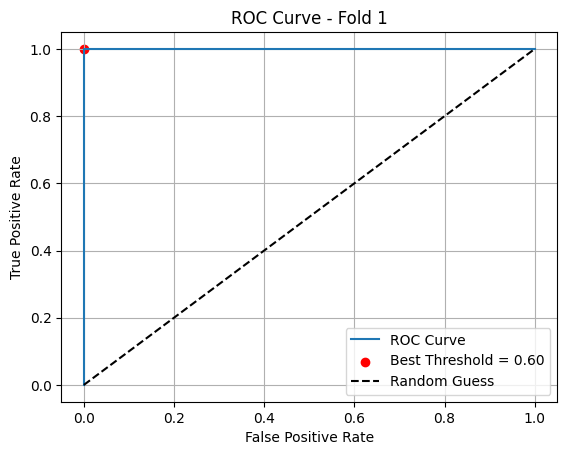

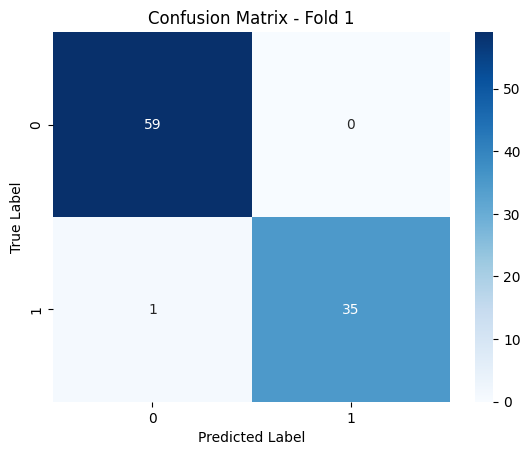



Fold 2: Accuracy = 0.968, Best Threshold = 0.68


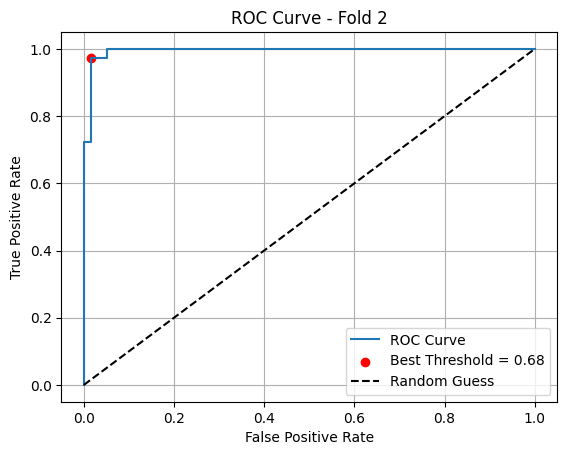

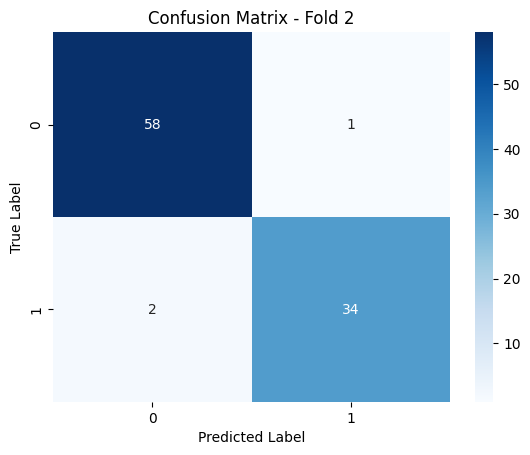



Fold 3: Accuracy = 0.947, Best Threshold = -0.77


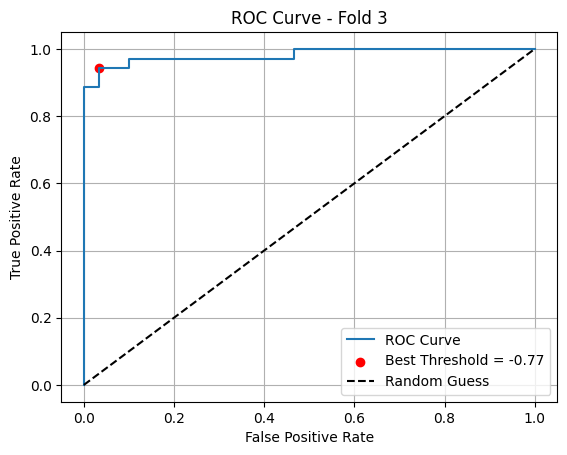

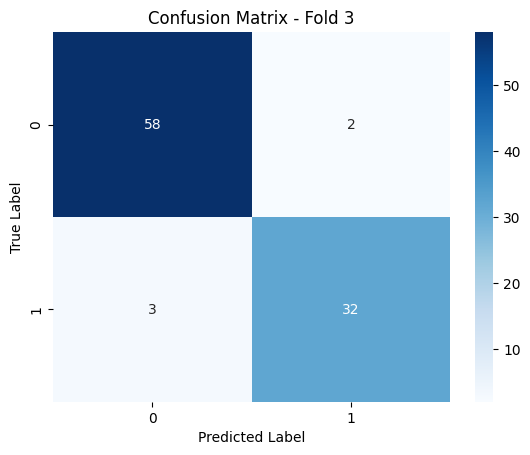



Fold 4: Accuracy = 0.958, Best Threshold = -0.27


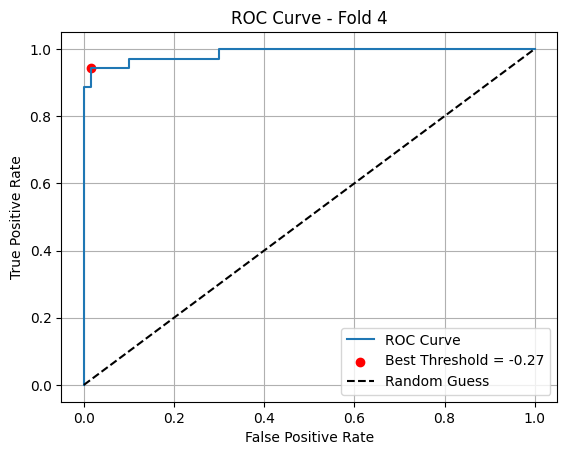

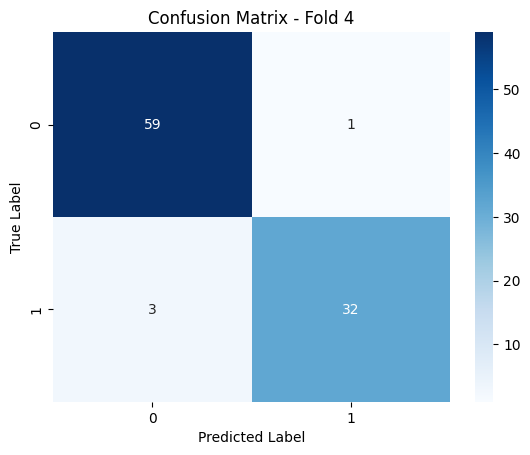



Fold 5: Accuracy = 0.989, Best Threshold = 0.79


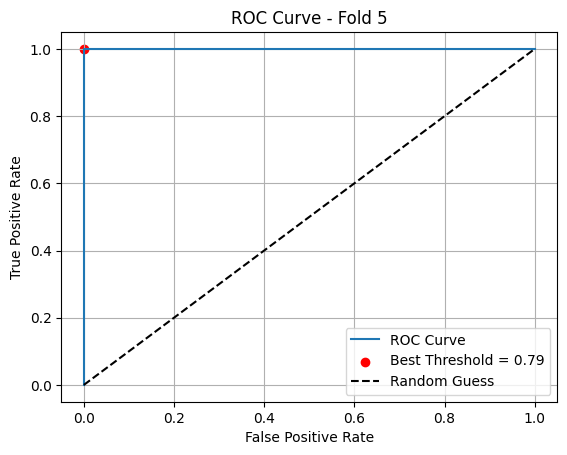

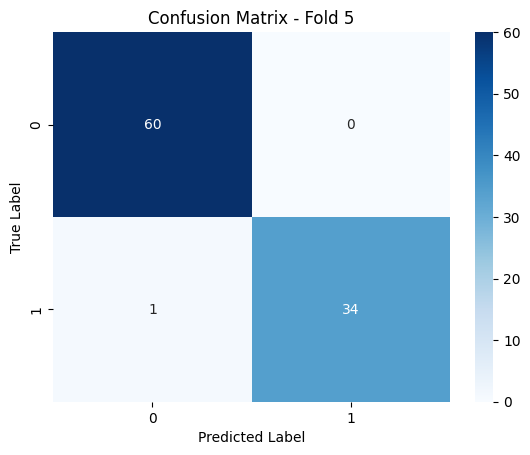



Fold 6: Accuracy = 0.979, Best Threshold = 0.05


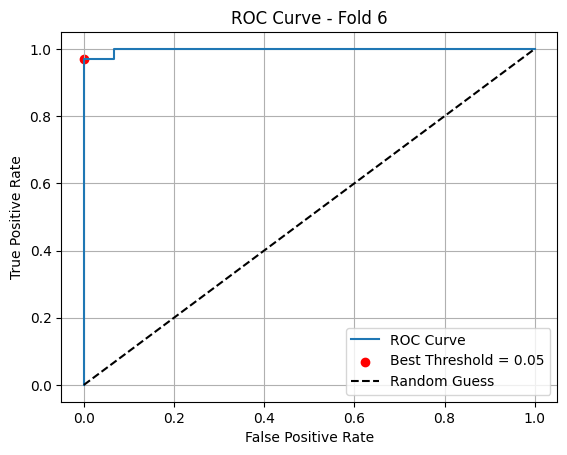

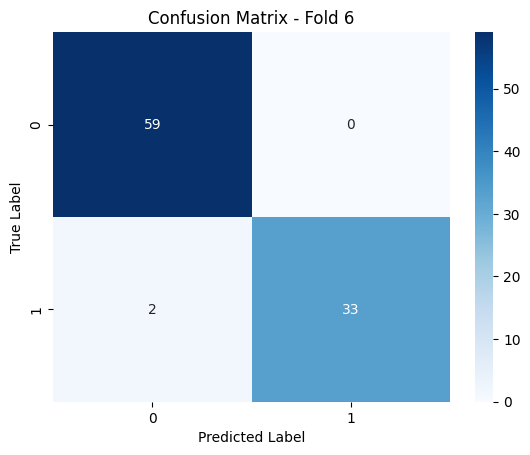


--- K-Fold Results ---
Average Accuracy: 0.9719
Average Best Threshold: 0.1782
Average Duration: 0.02 seconds


In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# K-Fold cross-validation function for SVM
def svm_k_fold_cross_validation(X, y, k=6):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    accuracies = []
    thresholds = []
    confusion_matrices = []
    durations = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Standardization
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train the model
        start = time.time()
        model = SVC(kernel='linear', probability=True, random_state=42)
        model.fit(X_train_scaled, y_train)

        # Get scores and plot ROC curve
        y_scores = model.decision_function(X_test_scaled)
        fpr, tpr, thresholds_all = roc_curve(y_test, y_scores)

        # Fawcett (Youden's J): Maximize TPR - FPR
        j_scores = tpr - fpr
        best_threshold = thresholds_all[np.argmax(j_scores)]
        thresholds.append(best_threshold)

        # Predict using the best threshold
        y_pred = (y_scores > best_threshold).astype(int)
        conf_matrix = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(conf_matrix)

        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

        durations.append(time.time() - start)

        print(f"\n\nFold {fold}: Accuracy = {acc:.3f}, Best Threshold = {best_threshold:.2f}")

        # print(conf_matrix)

        # Plot ROC Curve
        plt.figure()
        plt.plot(fpr, tpr, label='ROC Curve')
        plt.scatter(fpr[np.argmax(j_scores)], tpr[np.argmax(j_scores)], color='red', label=f'Best Threshold = {best_threshold:.2f}')
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.grid(True)
        plt.show()

        print("")

        # Plot Confusion Matrix
        plt.figure()
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    # Average results
    print("\n--- K-Fold Results ---")
    print(f"Average Accuracy: {np.mean(accuracies):.4f}")
    print(f"Average Best Threshold: {np.mean(thresholds):.4f}")
    print(f"Average Duration: {np.mean(durations):.2f} seconds")

# Call the function
svm_k_fold_cross_validation(classifier_data_x, classifier_data_y, k=6)


Comments

- The average accuracy is 97.19%, indicating that the model performs very well in classifying the data.
- True Negatives (TN) and True Positives (TP) are consistently high.
- False Positives (FP) and False Negatives (FN) remain low, mostly between 0 and 3.
- The highest number of errors occurred in Fold 3 (2 FPs + 3 FNs), showing that the model occasionally misclassifies both classes.
- False Positives are low: This means the model rarely misclassifies benign cases as malignant — a positive sign.
- False Negatives are more critical: Classifying malignant tumors as benign is riskier. Although FNs are low (max 3), they are important to monitor.
- All ROC curves look great — they go up quickly to the top-left, which means the model is doing a good job separating the two classes.
- Even though I didn’t calculate the AUC, I can tell from the shape that the AUC values are very close to 1, which is really good.

- Overall, the model performs really well across all folds.
- The accuracy is high, and the ROC curves show strong class separation.
- The thresholds change a lot between folds, so the decision boundary isn’t always at the same place. This could be because of small differences in the training/test data in each fold.

# **Part 4**

K-Fold Cross Validation

In [115]:
# K-Fold cross-validation function for SVR
def svr_k_fold_cross_validation(X, y, k=6):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    mse_list = []
    mae_list = []
    r2_list = []
    durations = []

    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Standardize the input features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Standardize the target values
        y_scaler = StandardScaler()
        y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
        y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

        # Train the SVR model
        model = SVR(kernel='linear')

        start_time = time.time()

        model.fit(X_train_scaled, y_train_scaled)
        y_pred_scaled = model.predict(X_test_scaled)

        # Inverse transform predictions to original scale
        y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        end_time = time.time()

        # Evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        duration = end_time - start_time

        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)
        durations.append(duration)

        print(f"Fold {fold}: MSE = {mse:.2f}, MAE = {mae:.2f}, R² = {r2:.4f}, Duration = {duration:.2f} sec")

    # Average results
    print("\n--- K-Fold Results ---")
    print(f"Average MSE: {np.mean(mse_list):.2f}")
    print(f"Average MAE: {np.mean(mae_list):.2f}")
    print(f"Average R²: {np.mean(r2_list):.4f}")
    print(f"Average Duration: {np.mean(durations):.2f} sec")

# Call the function
svr_k_fold_cross_validation(regressor_data_x, regressor_data_y, k=6)


Fold 1: MSE = 741301.24, MAE = 626.65, R² = 0.8273, Duration = 0.06 sec
Fold 2: MSE = 854531.51, MAE = 663.59, R² = 0.7513, Duration = 0.06 sec
Fold 3: MSE = 734608.00, MAE = 629.53, R² = 0.7831, Duration = 0.06 sec
Fold 4: MSE = 834920.00, MAE = 650.21, R² = 0.8006, Duration = 0.07 sec
Fold 5: MSE = 1011791.28, MAE = 728.83, R² = 0.6762, Duration = 0.05 sec
Fold 6: MSE = 625125.71, MAE = 611.06, R² = 0.8348, Duration = 0.06 sec

--- K-Fold Results ---
Average MSE: 800379.62
Average MAE: 651.64
Average R²: 0.7789
Average Duration: 0.06 sec


Comments

- The R² scores show that the model explains around 77.9% of the variance in the bike rental counts — not bad, but there's definitely room for improvement.

- Fold 5 had the worst performance, with the highest error and lowest R². There may be outliers or more complex patterns that linear SVR struggles to capture.

- MAE values around 600–700 show how far off predictions are on average — again, not terrible but not super precise either.

- The training time is minimal, which is expected with a linear model.

# **Part 5**

K-Fold Cross Validation

In [116]:
def evaluate_decision_tree(X, y, k=6, **dt_params):
    """
    Performs k-fold cross-validation for Decision Tree evaluation.
    Supports both pre-pruning (max_depth, min_samples_leaf) and post-pruning (ccp_alpha).

    Args:
        X (np.array): Input features
        y (np.array): Labels
        k (int): Number of folds for cross-validation
        dt_params (dict): Parameters for DecisionTreeClassifier

    Returns:
        model: The model trained on the last fold
        confusion_matrices: List of confusion matrices for each fold
    """
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    durations = []
    confusion_matrices = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Create the Decision Tree model with provided parameters
        model = DecisionTreeClassifier(random_state=42, **dt_params)

        # Train the model and measure training time
        start = time.time()
        model.fit(X_train, y_train)
        duration = time.time() - start

        # Make predictions and compute metrics
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        accuracies.append(acc)
        durations.append(duration)
        confusion_matrices.append(cm)

        print(f"Fold {fold}: Accuracy = {acc:.3f}, Duration = {duration:.2f} sec")

    # Print average results
    print("\n--- Cross-Validation Results ---")
    print(f"Average Accuracy: {np.mean(accuracies):.4f}")
    print(f"Average Duration: {np.mean(durations):.2f} seconds")

    return model, confusion_matrices


Prepruning Test

In [117]:
# Pre-pruning test
print("Pre:")
model_pre, conf_pre = evaluate_decision_tree(classifier_data_x, classifier_data_y, k=6, max_depth=5)

Pre:
Fold 1: Accuracy = 0.937, Duration = 0.01 sec
Fold 2: Accuracy = 0.937, Duration = 0.01 sec
Fold 3: Accuracy = 0.874, Duration = 0.01 sec
Fold 4: Accuracy = 0.947, Duration = 0.01 sec
Fold 5: Accuracy = 0.937, Duration = 0.01 sec
Fold 6: Accuracy = 0.947, Duration = 0.01 sec

--- Cross-Validation Results ---
Average Accuracy: 0.9297
Average Duration: 0.01 seconds


Postpruning Test

In [118]:
print("Post-pruning test")
model_post, conf_post = evaluate_decision_tree(classifier_data_x, classifier_data_y, k=6, ccp_alpha=0.009)

Post-pruning test
Fold 1: Accuracy = 0.937, Duration = 0.01 sec
Fold 2: Accuracy = 0.947, Duration = 0.01 sec
Fold 3: Accuracy = 0.874, Duration = 0.01 sec
Fold 4: Accuracy = 0.958, Duration = 0.01 sec
Fold 5: Accuracy = 0.958, Duration = 0.01 sec
Fold 6: Accuracy = 0.926, Duration = 0.01 sec

--- Cross-Validation Results ---
Average Accuracy: 0.9332
Average Duration: 0.01 seconds


Comments

- Post-pruning outperformed pre-pruning in terms of both accuracy and stability.

- Fold 3 consistently underperformed in both configurations, suggesting that this fold might contain more ambiguous or borderline samples.

- The pruning parameters were carefully tuned through trial and error, and the values presented were empirically selected as most optimal.

- Both models executed extremely fast.

- Pre-pruning applies limits during tree growth (like max_depth) to prevent overfitting early. However, it makes decisions without considering future splits, which means it might stop growing too early and miss useful patterns.

- Post-pruning, on the other hand, lets the tree grow fully and then prunes back less important branches. This helps keep useful complexity while reducing overfitting. But of course post-pruning is more complex.

Rule Extraction From Decision Trees

In [119]:
from sklearn.tree import _tree

def extract_rules_from_tree(tree_model, feature_names, target_names=None):
    """
    Prints rules from a decision tree, supporting both classification and regression trees.

    Args:
        tree_model: An sklearn DecisionTreeClassifier or DecisionTreeRegressor instance
        feature_names: List of feature names
        target_names: List of class names, required only for classification
    """
    tree_ = tree_model.tree_

    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            # Internal node: continue splitting
            name = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]
            recurse(tree_.children_left[node], path + [f"{name} <= {threshold:.2f}"])
            recurse(tree_.children_right[node], path + [f"{name} > {threshold:.2f}"])
        else:
            # Leaf node: print rule with prediction
            value = tree_.value[node][0]
            samples = int(np.sum(value))
            if target_names:  # CLASSIFICATION
                class_id = int(np.argmax(value))
                label = target_names[class_id]
                print("IF " + " AND ".join(path) + f" THEN class: {label}")
            else:  # REGRESSION
                prediction = value[0]
                print("IF " + " AND ".join(path) + f" THEN predict: {prediction:.2f}")

    recurse(0, [])

In [120]:
# for the model resulting from post-pruning
print("Total number of nodes in the tree:", model_post.tree_.node_count)
print("Feature at the root node:", model_post.tree_.feature[0])

feature_names = classifier_df.drop(columns=["Diagnosis"]).columns.tolist()
print(feature_names)

target_names = ['Benign', 'Malignant']  # names corresponding to 0 and 1

print("\n\nRules from the post-pruning model:")
extract_rules_from_tree(model_post, feature_names, target_names)

print("\n\nRules from the pre-pruning model:")
extract_rules_from_tree(model_pre, feature_names, target_names)


Total number of nodes in the tree: 13
Feature at the root node: 20
['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25', 'Feature_26', 'Feature_27', 'Feature_28', 'Feature_29', 'Feature_30']


Rules from the post-pruning model:
IF Feature_21 <= 16.80 AND Feature_28 <= 0.16 AND Feature_28 <= 0.14 THEN class: Benign
IF Feature_21 <= 16.80 AND Feature_28 <= 0.16 AND Feature_28 > 0.14 AND Feature_2 <= 20.78 THEN class: Benign
IF Feature_21 <= 16.80 AND Feature_28 <= 0.16 AND Feature_28 > 0.14 AND Feature_2 > 20.78 THEN class: Malignant
IF Feature_21 <= 16.80 AND Feature_28 > 0.16 THEN class: Malignant
IF Feature_21 > 16.80 AND Feature_27 <= 0.22 AND Feature_2 <= 21.26 THEN class: Benign
IF Feature_21 > 16.8

# **Part 6**

K-Fold Cross Validation

In [121]:
from sklearn.tree import DecisionTreeRegressor

def dt_regressor_k_fold(X, y, k=6, **dt_params):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    mse_list = []
    mae_list = []
    r2_list = []
    durations = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = DecisionTreeRegressor(max_depth=4, min_samples_split=10, random_state=42)

        start = time.time()
        model.fit(X_train_scaled, y_train)
        duration = time.time() - start

        y_pred = model.predict(X_test_scaled)

        # Evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)
        durations.append(duration)

        print(f"Fold {fold}: MSE={mse:.2f}, MAE={mae:.2f}, R²={r2:.4f}, Time={duration:.2f}s")

    # Average metrics
    print("\n--- K-Fold Results ---")
    print(f"Average MSE: {np.mean(mse_list):.2f}")
    print(f"Average MAE: {np.mean(mae_list):.2f}")
    print(f"Average R²: {np.mean(r2_list):.4f}")
    print(f"Average Time: {np.mean(durations):.2f} seconds")

    return model


In [122]:
dt_regressor_model = dt_regressor_k_fold(regressor_data_x, regressor_data_y, k=6)

Fold 1: MSE=787591.03, MAE=630.65, R²=0.8165, Time=0.00s
Fold 2: MSE=1112938.58, MAE=780.43, R²=0.6761, Time=0.00s
Fold 3: MSE=792326.17, MAE=670.16, R²=0.7660, Time=0.00s
Fold 4: MSE=1151561.77, MAE=743.31, R²=0.7250, Time=0.00s
Fold 5: MSE=860846.17, MAE=684.91, R²=0.7245, Time=0.00s
Fold 6: MSE=779935.61, MAE=620.70, R²=0.7939, Time=0.00s

--- K-Fold Results ---
Average MSE: 914199.89
Average MAE: 688.36
Average R²: 0.7503
Average Time: 0.00 seconds


Comments

- The R² score of ~0.75 shows that the model explains about 75% of the variance in bike rentals — a decent performance.

- Compared to KNN and SVR regressors, MSE and MAE are slightly higher, suggesting the Decision Tree may be less smooth and more sensitive to noise or outliers.

- Very fast training time, typical for decision trees.

In [123]:
feature_names = df.drop(columns=["cnt"]).columns.tolist()
extract_rules_from_tree(dt_regressor_model, feature_names)

IF temp <= -0.36 AND yr <= -0.00 AND season <= 0.43 AND temp <= -1.42 THEN predict: 1291.20
IF temp <= -0.36 AND yr <= -0.00 AND season <= 0.43 AND temp > -1.42 THEN predict: 1959.44
IF temp <= -0.36 AND yr <= -0.00 AND season > 0.43 AND hum <= 1.62 THEN predict: 3531.89
IF temp <= -0.36 AND yr <= -0.00 AND season > 0.43 AND hum > 1.62 THEN predict: 979.67
IF temp <= -0.36 AND yr > -0.00 AND temp <= -1.20 AND hum <= 1.13 THEN predict: 2863.69
IF temp <= -0.36 AND yr > -0.00 AND temp <= -1.20 AND hum > 1.13 THEN predict: 1378.75
IF temp <= -0.36 AND yr > -0.00 AND temp > -1.20 AND mnth <= 1.12 THEN predict: 3876.24
IF temp <= -0.36 AND yr > -0.00 AND temp > -1.20 AND mnth > 1.12 THEN predict: 5060.24
IF temp > -0.36 AND yr <= -0.00 AND weathersit <= 2.04 AND mnth <= -0.62 THEN predict: 3648.43
IF temp > -0.36 AND yr <= -0.00 AND weathersit <= 2.04 AND mnth > -0.62 THEN predict: 4504.90
IF temp > -0.36 AND yr <= -0.00 AND weathersit > 2.04 THEN predict: 2281.43
IF temp > -0.36 AND yr > -